# Different permeation regimes

Let's start by making a parametric FESTIM model taking as parameters the size of the domain, the upstream pressure, the surface rate coefficients, and the diffusivity.

In [1]:
import festim as F
import numpy as np


def compute_permeation_flux(L, P_up, K_r_, K_d, D):
    my_model = F.Simulation(log_level=40)

    my_model.mesh = F.MeshFromVertices(vertices=np.linspace(0, L, num=10))

    my_model.materials = F.Material(id=1, D_0=D, E_D=0)

    my_model.boundary_conditions = [
        F.DissociationFlux(Kd_0=K_d, E_Kd=0, P=P_up, surfaces=1),
        F.RecombinationFlux(Kr_0=K_r_, E_Kr=0, order=2, surfaces=[1, 2]),
    ]

    my_model.T = 300  # ignored here

    my_model.settings = F.Settings(
        absolute_tolerance=1e-7,
        relative_tolerance=1e-10,
        transient=True,
        final_time=100,
    )

    my_model.dt = F.Stepsize(0.01, stepsize_change_ratio=1.1)

    permeation_flux = F.HydrogenFlux(surface=2)
    surface_concentration = F.TotalSurface(field="solute", surface=1)
    surface_concentration_L = F.TotalSurface(field="solute", surface=2)
    my_model.exports = [
        F.DerivedQuantities(
            [permeation_flux, surface_concentration, surface_concentration_L],
            show_units=True,
        ),
        F.TXTExport(field=0, filename=f"./pressure_{P_up:.2e}.txt"),
    ]

    my_model.initialise()
    my_model.run()

    return permeation_flux, surface_concentration, surface_concentration_L

We can run this model for a range of upstream pressures. We choose arbitrary values for rate coefficients, diffusivities, and length.

In [2]:
K_r = 10
K_d = 100
L = 1
D = 2
fluxes = []
concentrations_0 = []
concentrations_L = []
pressures = np.logspace(-6, 4, num=9)
for P_up in pressures:
    print(f" ---- P = {P_up:.2e} ----")
    flux, c_surf_0, c_surf_L = compute_permeation_flux(L, P_up, K_r, K_d, D)
    fluxes.append(flux)
    concentrations_0.append(c_surf_0)
    concentrations_L.append(c_surf_L)

 ---- P = 1.00e-06 ----
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
100.0 %        1.0e+02 s    Elapsed time so far: 1.1 s
 ---- P = 1.78e-05 ----
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
100.0 %        1.0e+02 s    Elapsed time so far: 0.9 s
 ---- P = 3.16e-04 ----
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
100.0 %        1.0e+02 s    Elapsed time so far: 1.0 s
 ---- P = 5.62e-03 ----
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
100.0 %        1.0e+02 s    Elapsed time so far: 0.9 s
 ---- P = 1.00e-01 ----
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
100.0 %        1.0e+02 s    Elapsed time so far: 0.9 s


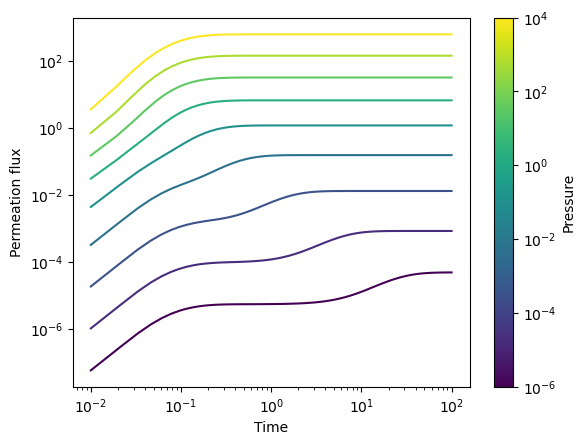

In [3]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

norm = mcolors.LogNorm(vmin=pressures[0], vmax=pressures[-1])

for i, P in enumerate(pressures):
    plt.loglog(
        fluxes[i].t,
        np.abs(fluxes[i].data),
        label=f"P={P}",
        color=plt.cm.viridis(norm(P)),
    )

plt.colorbar(
    plt.cm.ScalarMappable(norm=norm, cmap="viridis"), label="Pressure", ax=plt.gca()
)
plt.xlabel("Time")
plt.ylabel("Permeation flux")
plt.show()

In [4]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

def make_animation(P):
    data = np.genfromtxt(
        f"pressure_{P:.2e}.txt", delimiter=",", skip_header=1
    )


    x = data[:, 0]
    # order x
    order = np.argsort(x)
    x = x[order]

    fig, ax = plt.subplots()
    (line1,) = ax.plot([], [], lw=2, color="black")

    def init():
        line1.set_data([], [])
        ax.set_xlim(0, L)
        ax.set_ylim(bottom=0, top=np.max(data[:, 1:])*1.1)
        ax.set_xlabel(r"x")
        ax.set_ylabel(r"H concentration")
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)

        return [line1]


    def animate(i):
        c = data[:, i+1][order]
        line1.set_data(x, c)
        return [line1]


    # Call the animator
    ani = animation.FuncAnimation(
        fig, animate, init_func=init, frames=data.shape[1]-1, interval=50, blit=True
    )

    plt.close(fig)

    return HTML(ani.to_jshtml())

make_animation(pressures[0])

In [5]:
make_animation(pressures[-4])

## Evolution of the permeation flux as a function of pressure

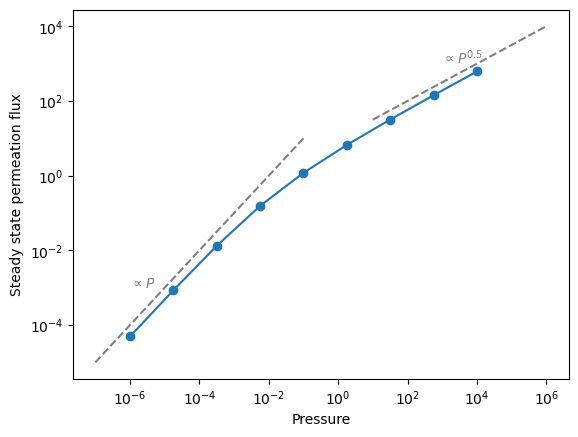

In [12]:
steady_state_fluxes = np.abs([flux.data[-1] for flux in fluxes])

plt.plot(pressures, steady_state_fluxes, marker="o")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Pressure")
plt.ylabel("Steady state permeation flux")

Ps_linear = np.logspace(-7, -1)
Ps_squared = np.logspace(1, 6)
plt.plot(Ps_linear, Ps_linear * 100, linestyle="--", color="gray")
plt.plot(Ps_squared, Ps_squared**0.5 * 10, linestyle="--", color="gray")

plt.annotate(r"$\propto P$", (1e-6, 1e-3), color="gray")
plt.annotate(r"$\propto P^{0.5}$", (1e3, 1e3) , color="gray")
plt.show()

## Validity of hypotheses on surface concentrations

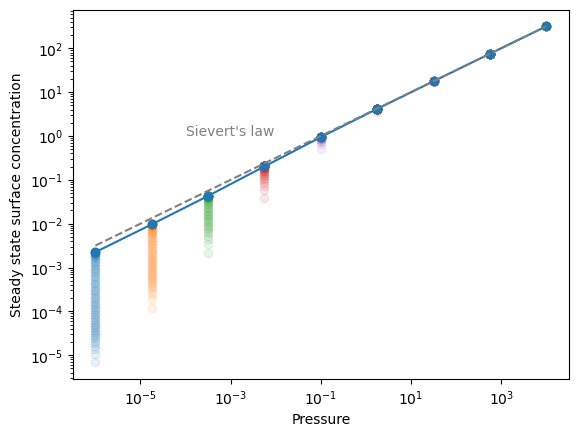

In [7]:
plt.plot(pressures, [c.data[-1] for c in concentrations_0], marker="o")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Pressure")
plt.ylabel("Steady state surface concentration")

plt.plot(
    pressures, (np.array(pressures) * K_d / K_r) ** 0.5, linestyle="--", color="gray"
)

for i, P in enumerate(pressures):
    plt.scatter(np.ones_like(concentrations_0[i].data) * P, concentrations_0[i].data, alpha=0.1)

plt.annotate("Sievert's law", (1e-4, 1e0), textcoords="data", color="gray")
plt.show()

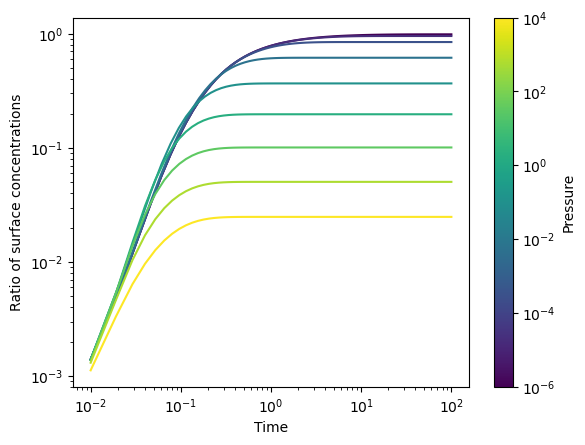

In [8]:
for i, P in enumerate(pressures):
    ratio = np.array(concentrations_L[i].data) / np.array(concentrations_0[i].data)
    plt.loglog(
        concentrations_L[i].t, ratio, label=f"P={P}", color=plt.cm.viridis(norm(P))
    )

plt.xlabel("Time")
plt.ylabel("Ratio of surface concentrations")
plt.colorbar(
    plt.cm.ScalarMappable(norm=norm, cmap="viridis"), label="Pressure", ax=plt.gca()
)

plt.show()

At high pressures (diffusion-limited regime), the concentration on the downstream is negligible to the concentration on the upstream surface.

However, at low pressures (surface-limited regime), both concentrations are more and more comparable and assuming $c=0$ on the downstream face isn't valid.

Text(0, 0.5, '$c_L$')

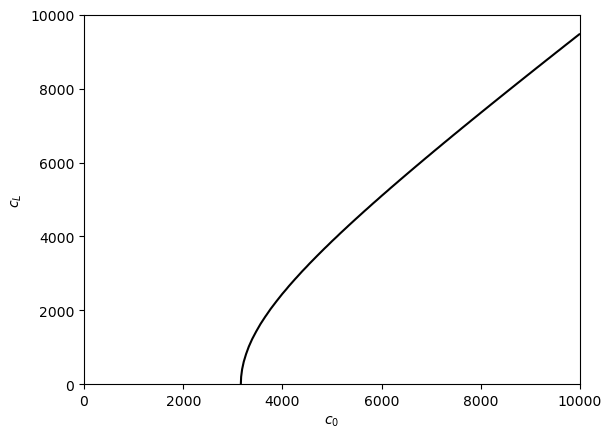

In [9]:
c0s = np.linspace(0, 1e4)
cls = np.linspace(0, 1e4)
P = 1e6
c00, cll = np.meshgrid(c0s, cls)

flux_left = -K_d * P + K_r * c00**2
flux_right = K_r * cll**2

ZZ = flux_left - flux_right
import matplotlib.pyplot as plt

plt.figure()
plt.contour(c0s, cls, ZZ, levels=[0], colors="black")
# plt.contourf(c0s, cls, np.abs(ZZ), levels=100)

plt.xlabel("$c_0$")
plt.ylabel("$c_L$")
# plt.xscale('log')
# plt.yscale('log')